The following implementation is based on the work of Carillo, Huang, Schmidtchen found at https://arxiv.org/abs/1705.03320

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def W11(x):
    return (x**2)/2
def W22(x):
    return W11(x)
def W12(x):
    return abs(x)
def W21(x):
    return W12(x)

In [3]:
#Implementation of the Finite Volume Method Scheme of Section 3
class aggregation_diffusion_2species:
    
    def __init__(self, L: float, T: float, N: int, dt: float, epsilon: float, init_rho: np.ndarray, init_eta: np.ndarray):
        """
        L: Right boundary point in x dimension, PDE definied on [-L, L]
        T: End time, approximation PDE on [0, T]
        N: Number of Cells on [-L, L]
        dt: Temporal step size
        epsilon: cross-diffusivity coefficient
        init_rho: initial data for rho at time 0
        init_eta: initial data for eta at time 0

        """
        self.L = L
        self.T = T
        self.N = N
        self.dt = dt
        self.eps = epsilon
        self.dx = 2*L/N #Spacial Stepsize
        self.init_rho = init_rho
        self.init_eta = init_eta
        self.Ci = np.linspace(-L + self.dx/2, L - self.dx/2, N+1) #End points of Cells
        self.Xi = np.linspace(-L, L, N+1) #Spacial Discretization
        self.rho = np.zeros((int(T/dt)+1, len(self.Ci)))
        self.eta = np.zeros((int(T/dt)+1, len(self.Ci)))
        self.rho[0, :] = self.init_rho
        self.eta[0, :] = self.init_eta
        
        #Self-Interaction and Cross-Interaction Potentials
        self.matW11 = np.zeros((len(self.Xi), len(self.Xi)))
        self.matW12 = np.zeros((len(self.Xi), len(self.Xi)))
        self.matW21 = np.zeros((len(self.Xi), len(self.Xi)))
        self.matW22 = np.zeros((len(self.Xi), len(self.Xi)))
        for i in range(len(self.Ci)):
            for j in range(len(self.Ci)):
                self.matW11[i, j] = W11(self.Xi[i]-self.Xi[j])
                self.matW12[i, j] = W12(self.Xi[i]-self.Xi[j])
                self.matW21[i, j] = W21(self.Xi[i]-self.Xi[j])
                self.matW22[i, j] = W22(self.Xi[i]-self.Xi[j])
                
    def solve(self):
        for n in range(1, int(self.T/self.dt)+1):
            F, G = self.flux(n-1)
            # Equation (6a)
            self.rho[n, 1:-1] = self.rho[n-1, 1:-1] - (self.dt/self.dx)*(F[1:]-F[:-1])
            self.eta[n, 1:-1] = self.eta[n-1, 1:-1] - (self.dt/self.dx)*(G[1:] - G[:-1])
        return self.rho, self.eta
    
    def flux(self, t_ind):
        U , V = self.velocity(t_ind)
        zero_vec = np.zeros_like(U)
        # Equation (6b)
        F = np.maximum(U, zero_vec)*self.rho[t_ind, :-1] + np.minimum(U, zero_vec)*self.rho[t_ind, 1:]
        G = np.maximum(V, zero_vec)*self.eta[t_ind, :-1] + np.minimum(V, zero_vec)*self.eta[t_ind, 1:]
        return F, G
        
        
        
    def velocity(self, t_ind):
        # Equation (6d)
        xi = self.dx*(self.matW11@self.rho[t_ind, :] + self.matW12@self.eta[t_ind, :]) + self.eps*(self.rho[t_ind, :]+self.eta[t_ind, :])
        zeta = self.dx*(self.matW22@self.eta[t_ind, :] + self.matW21@self.rho[t_ind, :]) + self.eps*(self.rho[t_ind, :]+self.eta[t_ind, :])
        return -(xi[1:] - xi[:-1])/self.dx, -(zeta[1:]-zeta[:-1])/self.dx
        
         
        

## Attractive-Attractive Case (Section 4.1)

## Figure 2(b)

In [4]:
L = 1
eps = 0.12
m1 = 0.6
m2= 0.1
T = 12
N = 200
dt = 0.0001

def rho0(x):
    if abs(x) >= 0 and abs(x) <= 0.5:
        return m1
    else:
        return 0
def eta0(x):
    if abs(x)>= 0 and abs(x) <= 0.1:
        return m2
    else:
        return 0
X = np.linspace(-L, L, N+1)
init_rho = np.array([rho0(x) for x in X])
init_eta = np.array([eta0(x) for x in X])

solver = aggregation_diffusion_2species(L, T, N, dt, eps, init_rho, init_eta)

rho, eta = solver.solve()

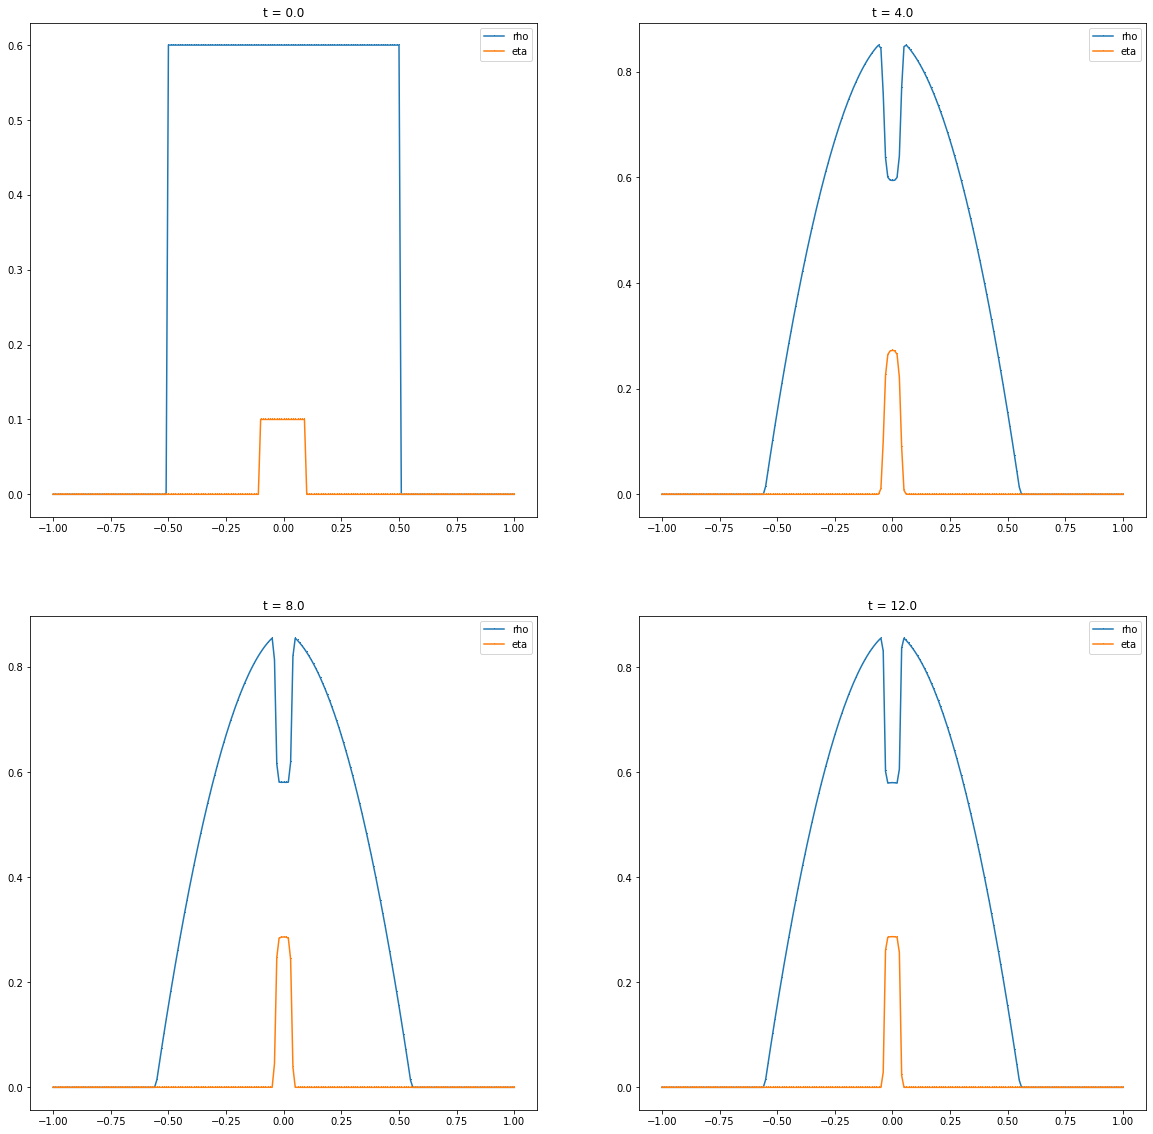

In [5]:
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(20,20))
length = rho.shape[0]
for i in range(2):
    for j in range(2):
        ax[j, i].plot(X, rho[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'rho')
        ax[j, i].plot(X, eta[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'eta')
        ax[j, i].set_title(f't = {(int((2*j + i)/3*(length-1)))*dt}')
        ax[j, i].legend()

## Figure 6

In [6]:
L = 3
eps = 1.7
m1 = 0.125
m2 = 0.4
T = 48
N = 150
dt = 0.0005

def rho0(x):
    if abs(x) >= 0 and abs(x) <= 2.5:
        return m1
    else:
        return 0
def eta0(x):
    if abs(x)>= 0 and abs(x) <= 0.2:
        return m2
    else:
        return 0
X = np.linspace(-L, L, N+1)
init_rho = np.array([rho0(x) for x in X])
init_eta = np.array([eta0(x) for x in X])

solver = aggregation_diffusion_2species(L, T, N, dt, eps, init_rho, init_eta)


rho, eta = solver.solve()

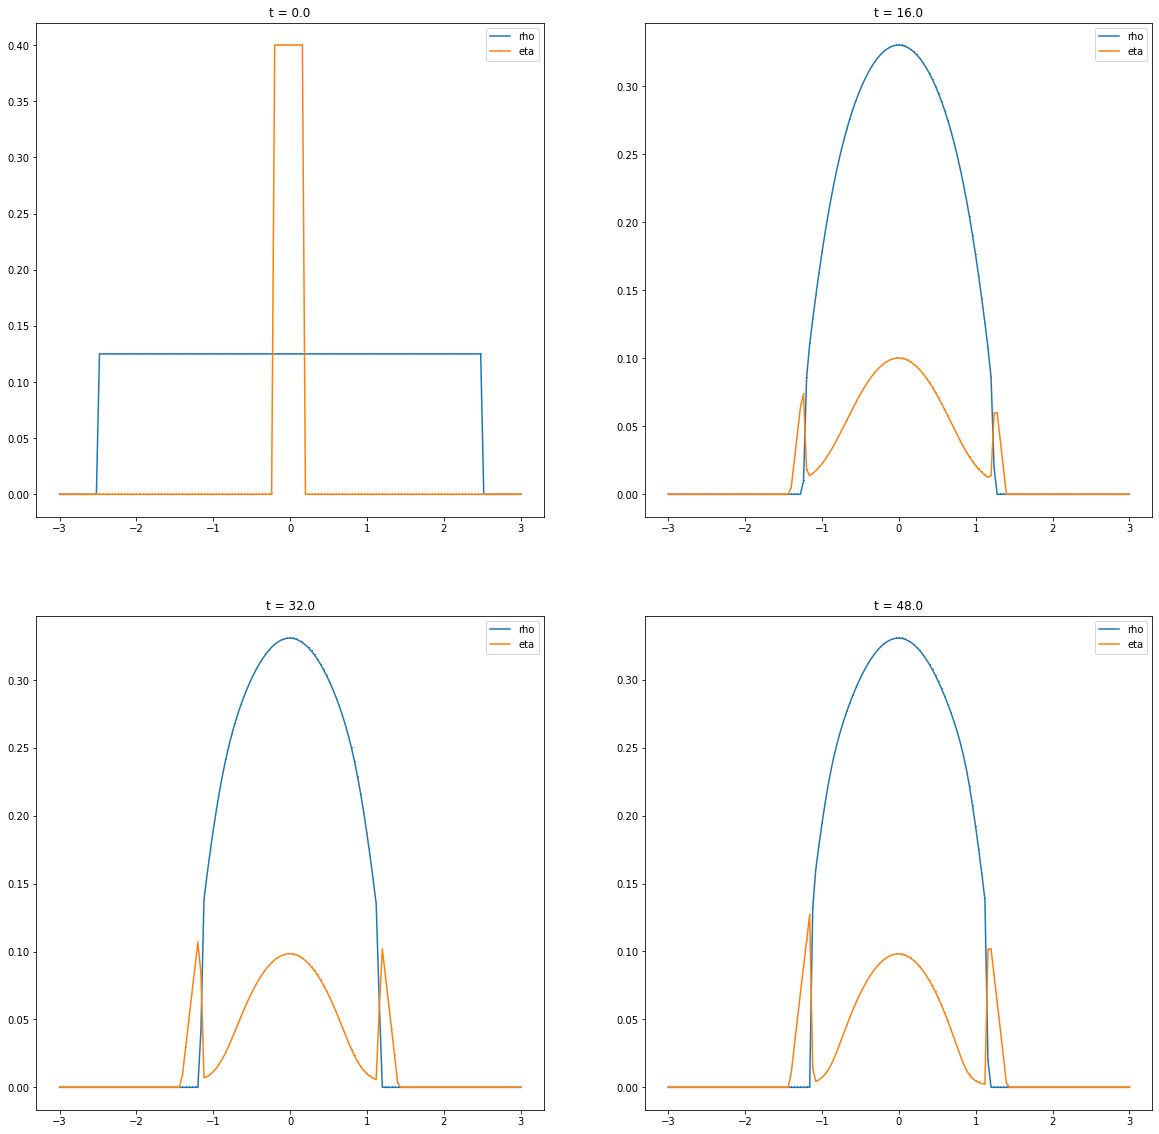

In [7]:
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(20,20))
length = rho.shape[0]
for i in range(2):
    for j in range(2):
        ax[j, i].plot(X, rho[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'rho')
        ax[j, i].plot(X, eta[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'eta')
        ax[j, i].set_title(f't = {(int((2*j + i)/3*(length-1)))*dt}')
        ax[j, i].legend()

In [8]:
L = 3
eps = 1.7
m1 = 0.6
m2 = 0.05
T = 48
N = 150
dt = 0.0005

def rho0(x):
    if abs(x) >= 0 and abs(x) <= 0.5:
        return m1
    else:
        return 0
def eta0(x):
    if abs(x)>= 0.5 and abs(x) <= 1.5:
        return m2
    else:
        return 0
X = np.linspace(-L, L, N+1)
init_rho = np.array([rho0(x) for x in X])
init_eta = np.array([eta0(x) for x in X])

solver = aggregation_diffusion_2species(L, T, N, dt, eps, init_rho, init_eta)
rho, eta = solver.solve()


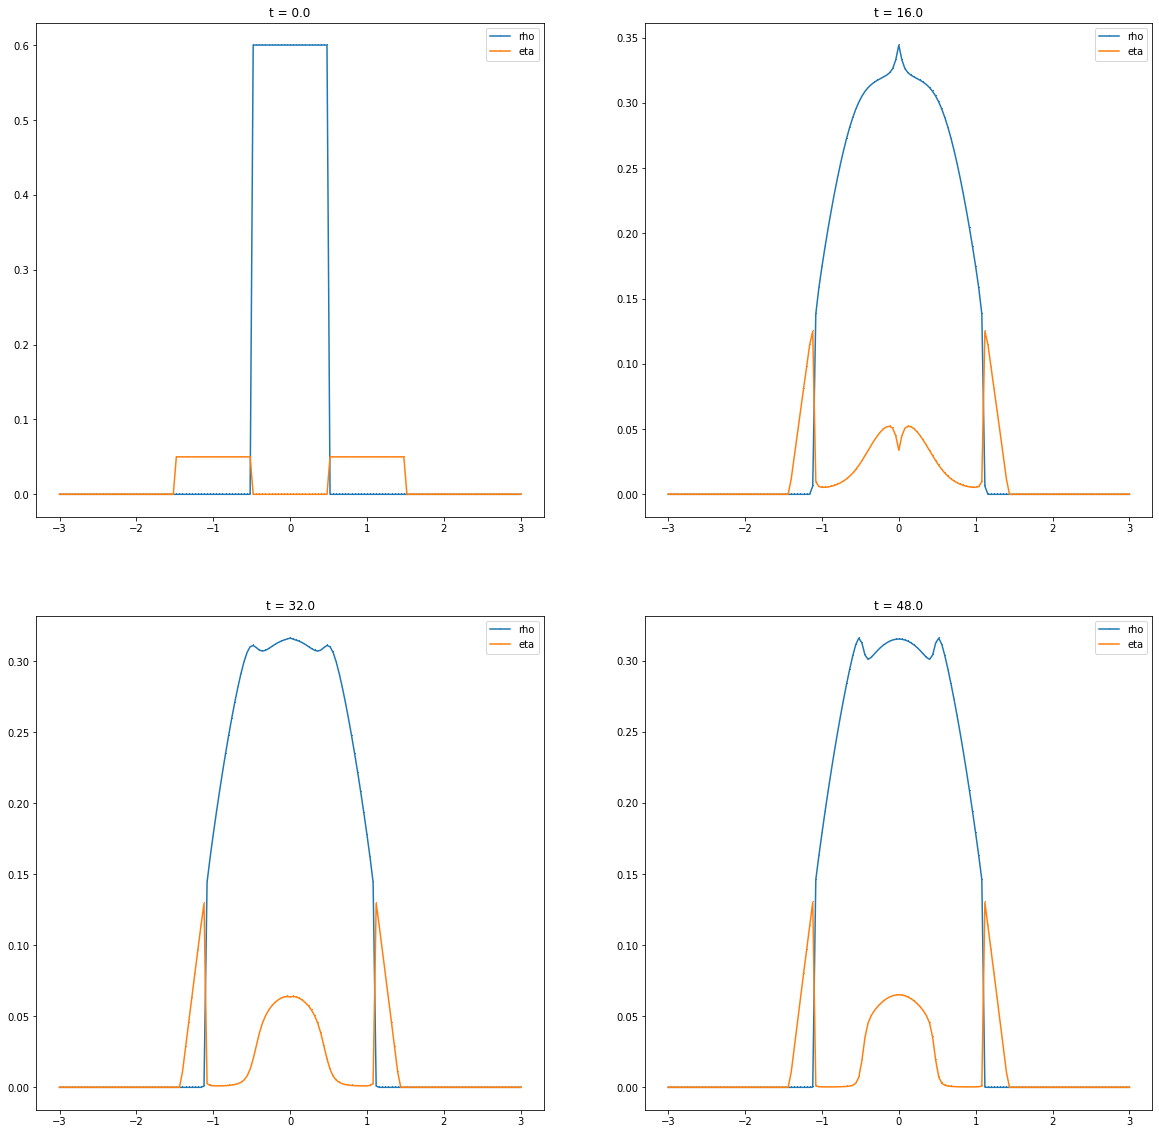

In [9]:
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(20,20))
length = rho.shape[0]
for i in range(2):
    for j in range(2):
        ax[j, i].plot(X, rho[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'rho')
        ax[j, i].plot(X, eta[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'eta')
        ax[j, i].set_title(f't = {(int((2*j + i)/3*(length-1)))*dt}')
        ax[j, i].legend()

## Figure 8

In [10]:
L = 3
eps = 3
m1 = 1
m2 = 0.5
T = 12
N = 50
dt = 0.0001

def rho0(x):
    if x >= -0.5 and x <= 0:
        return 2*m1
    else:
        return 0
def eta0(x):
    if x<= 0.5 and x >= 0:
        return 2*m2
    else:
        return 0
X = np.linspace(-L, L, N+1)
init_rho = np.array([rho0(x) for x in X])
init_eta = np.array([eta0(x) for x in X])

solver = aggregation_diffusion_2species(L, T, N, dt, eps, init_rho, init_eta)
rho, eta = solver.solve()


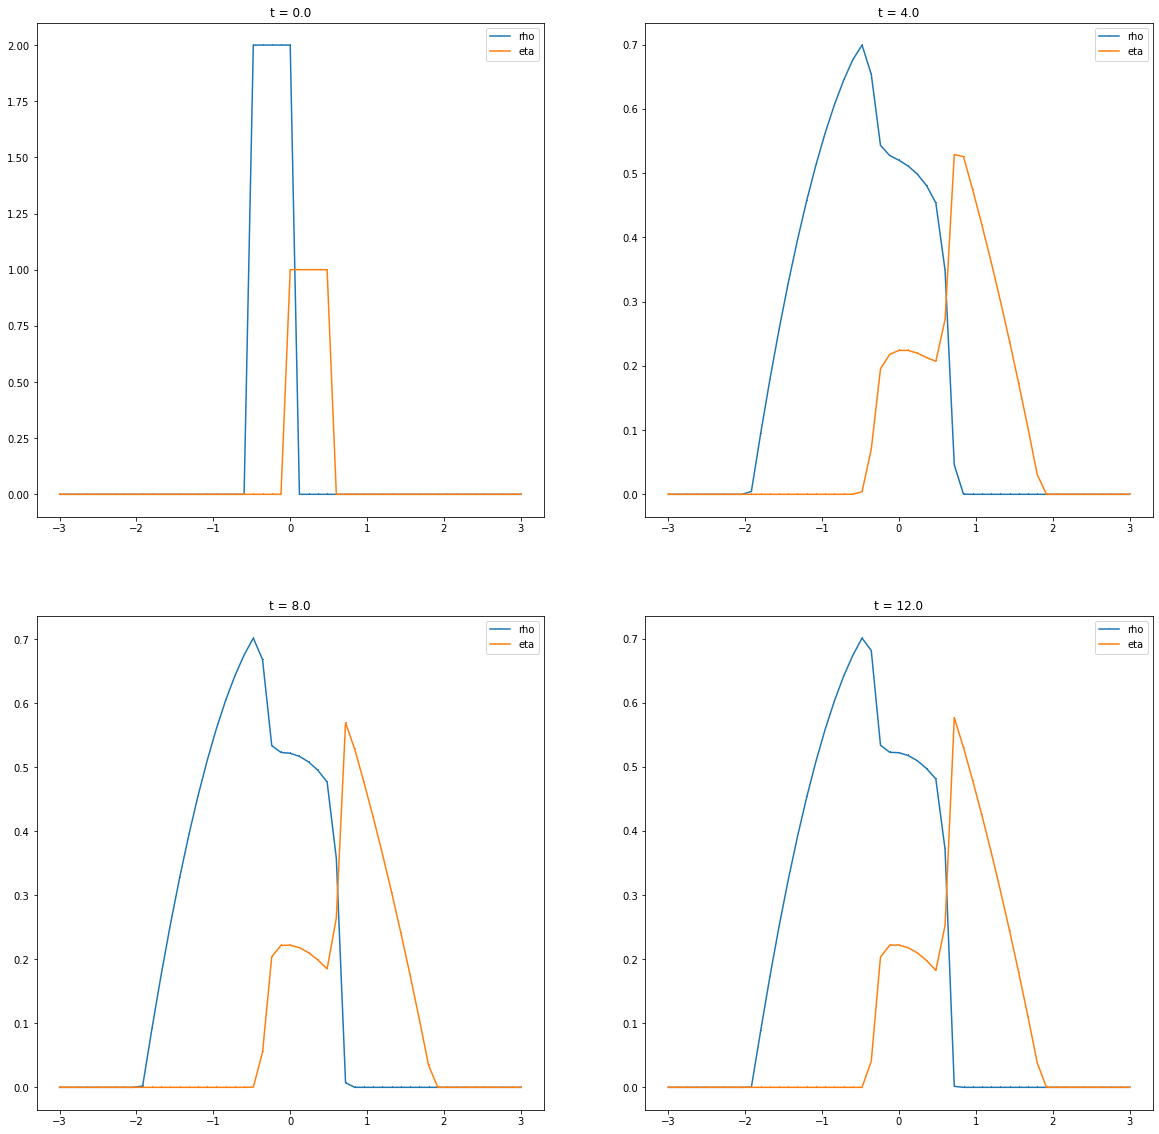

In [11]:
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(20,20))
length = rho.shape[0]
for i in range(2):
    for j in range(2):
        ax[j, i].plot(X, rho[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'rho')
        ax[j, i].plot(X, eta[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'eta')
        ax[j, i].set_title(f't = {(int((2*j + i)/3*(length-1)))*dt}')
        ax[j, i].legend()

In [12]:
L = 3
eps = 3
m1 = 1
m2 = 1
T = 12
N = 100
dt = 0.0001

def rho0(x):
    if x >= -0.5 and x <= 0:
        return 2*m1
    else:
        return 0
def eta0(x):
    if x<= 0.5 and x >= 0:
        return 2*m2
    else:
        return 0
X = np.linspace(-L, L, N+1)
init_rho = np.array([rho0(x) for x in X])
init_eta = np.array([eta0(x) for x in X])

solver = aggregation_diffusion_2species(L, T, N, dt, eps, init_rho, init_eta)
rho, eta = solver.solve()


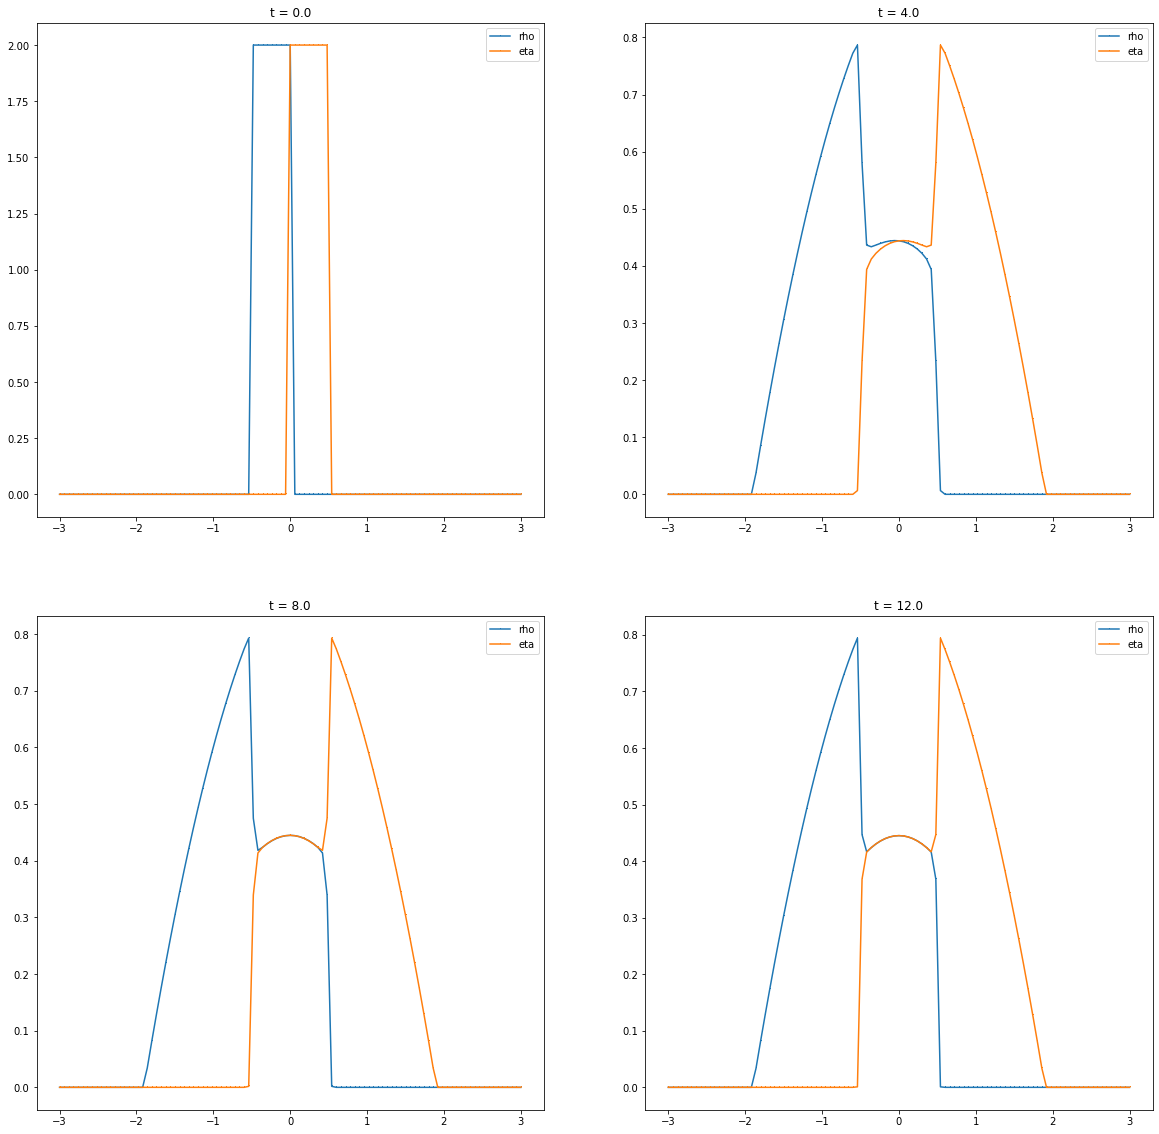

In [13]:
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(20,20))
length = rho.shape[0]
for i in range(2):
    for j in range(2):
        ax[j, i].plot(X, rho[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'rho')
        ax[j, i].plot(X, eta[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'eta')
        ax[j, i].set_title(f't = {(int((2*j + i)/3*(length-1)))*dt}')
        ax[j, i].legend()

## Attractive-Repulsive Case (Section 4.2)

In [14]:
def W11(x):
    return (x**2)/2
def W22(x):
    return W11(x)
def W12(x):
    return abs(x)
def W21(x):
    return -W12(x)

#Implementation of the Finite Volume Method Scheme of Section 3
#Rerunning this Cell since Interaction Potentials have changed
class aggregation_diffusion_2species:
    
    def __init__(self, L: float, T: float, N: int, dt: float, epsilon: float, init_rho: np.ndarray, init_eta: np.ndarray):
        """
        L: Right boundary point in x dimension, PDE definied on [-L, L]
        T: End time, approximation PDE on [0, T]
        N: Number of Cells on [-L, L]
        dt: Temporal step size
        epsilon: cross-diffusivity coefficient
        init_rho: initial data for rho at time 0
        init_eta: initial data for eta at time 0

        """
        self.L = L
        self.T = T
        self.N = N
        self.dt = dt
        self.eps = epsilon
        self.dx = 2*L/N #Spacial Stepsize
        self.init_rho = init_rho
        self.init_eta = init_eta
        self.Ci = np.linspace(-L + self.dx/2, L - self.dx/2, N+1) #End points of Cells
        self.Xi = np.linspace(-L, L, N+1) #Spacial Discretization
        self.rho = np.zeros((int(T/dt)+1, len(self.Ci)))
        self.eta = np.zeros((int(T/dt)+1, len(self.Ci)))
        self.rho[0, :] = self.init_rho
        self.eta[0, :] = self.init_eta
        
        #Self-Interaction and Cross-Interaction Potentials
        self.matW11 = np.zeros((len(self.Xi), len(self.Xi)))
        self.matW12 = np.zeros((len(self.Xi), len(self.Xi)))
        self.matW21 = np.zeros((len(self.Xi), len(self.Xi)))
        self.matW22 = np.zeros((len(self.Xi), len(self.Xi)))
        for i in range(len(self.Ci)):
            for j in range(len(self.Ci)):
                self.matW11[i, j] = W11(self.Xi[i]-self.Xi[j])
                self.matW12[i, j] = W12(self.Xi[i]-self.Xi[j])
                self.matW21[i, j] = W21(self.Xi[i]-self.Xi[j])
                self.matW22[i, j] = W22(self.Xi[i]-self.Xi[j])
                
    def solve(self):
        for n in range(1, int(self.T/self.dt)+1):
            F, G = self.flux(n-1)
            # Equation (6a)
            self.rho[n, 1:-1] = self.rho[n-1, 1:-1] - (self.dt/self.dx)*(F[1:]-F[:-1])
            self.eta[n, 1:-1] = self.eta[n-1, 1:-1] - (self.dt/self.dx)*(G[1:] - G[:-1])
        return self.rho, self.eta
    
    def flux(self, t_ind):
        U , V = self.velocity(t_ind)
        zero_vec = np.zeros_like(U)
        # Equation (6b)
        F = np.maximum(U, zero_vec)*self.rho[t_ind, :-1] + np.minimum(U, zero_vec)*self.rho[t_ind, 1:]
        G = np.maximum(V, zero_vec)*self.eta[t_ind, :-1] + np.minimum(V, zero_vec)*self.eta[t_ind, 1:]
        return F, G
        
        
        
    def velocity(self, t_ind):
        # Equation (6d)
        xi = self.dx*(self.matW11@self.rho[t_ind, :] + self.matW12@self.eta[t_ind, :]) + self.eps*(self.rho[t_ind, :]+self.eta[t_ind, :])
        zeta = self.dx*(self.matW22@self.eta[t_ind, :] + self.matW21@self.rho[t_ind, :]) + self.eps*(self.rho[t_ind, :]+self.eta[t_ind, :])
        return -(xi[1:] - xi[:-1])/self.dx, -(zeta[1:]-zeta[:-1])/self.dx
        
         
        

## $\epsilon = \frac{1}{20}$

In [15]:
L = 2
eps = 0.05
m1 = 1
m2 = 1
T = 3
N = 150
dt = 0.0005

def rho0(x):
    if abs(x) >= 0 and abs(x) <= 0.5:
        return m1
    else:
        return 0
def eta0(x):
    if abs(x)>= 0.5 and abs(x) <= 1:
        return m2
    else:
        return 0
X = np.linspace(-L, L, N+1)
init_rho = np.array([rho0(x) for x in X])
init_eta = np.array([eta0(x) for x in X])

solver = aggregation_diffusion_2species(L, T, N, dt, eps, init_rho, init_eta)


rho, eta = solver.solve()

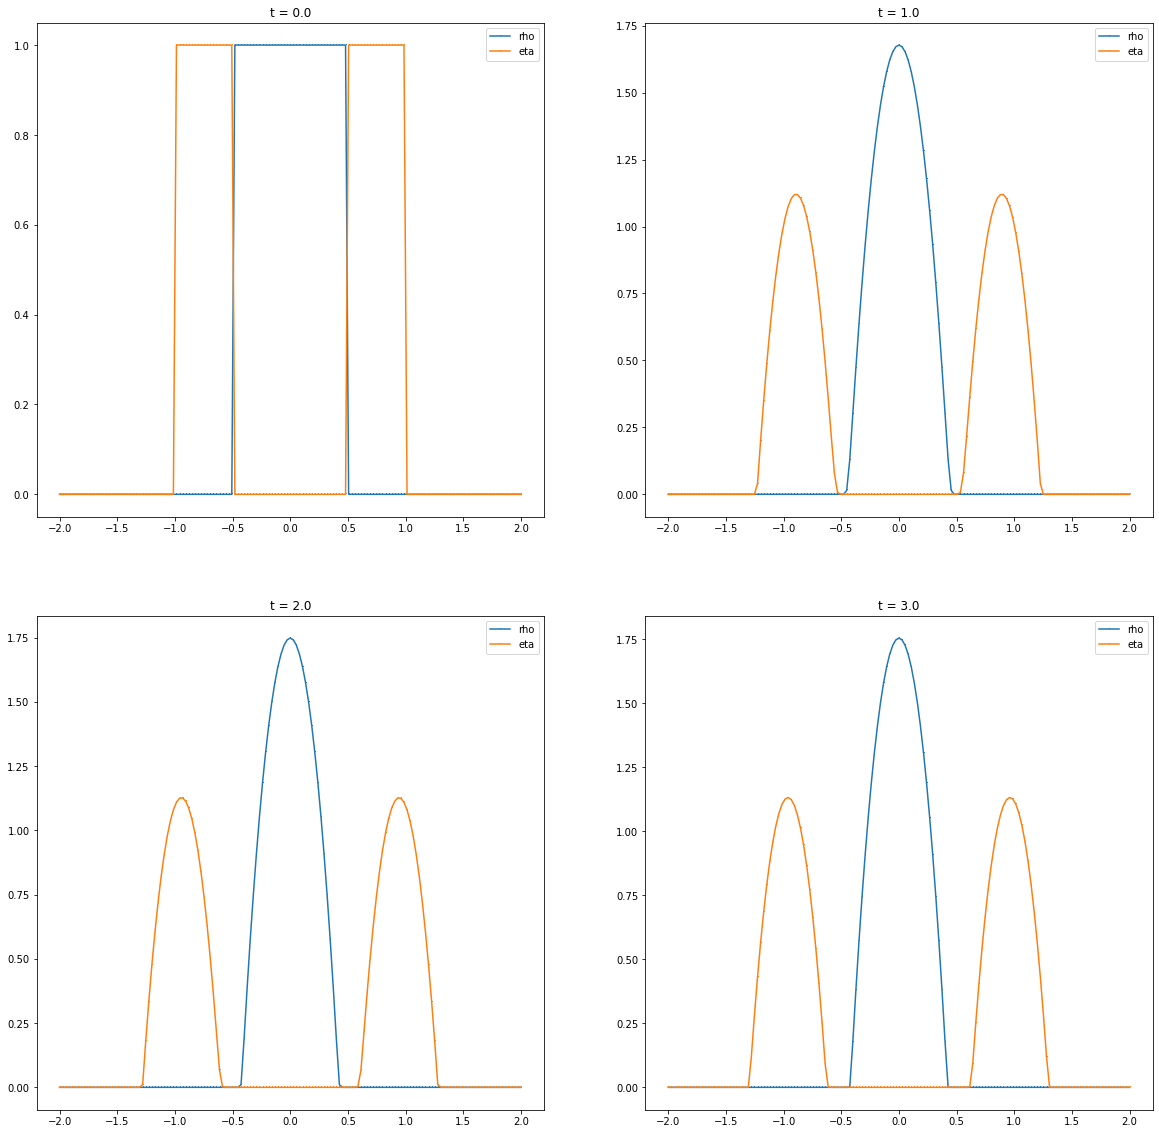

In [16]:
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(20,20))
length = rho.shape[0]
for i in range(2):
    for j in range(2):
        ax[j, i].plot(X, rho[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'rho')
        ax[j, i].plot(X, eta[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'eta')
        ax[j, i].set_title(f't = {(int((2*j + i)/3*(length-1)))*dt}')
        ax[j, i].legend()

## $\epsilon = \frac{4}{9} \left( 2^{1/3} - 1 \right)$

In [17]:
L = 2
eps = (4/9)*(2**(1/3)-1)
m1 = 1
m2 = 1
T = 3
N = 150
dt = 0.0005

def rho0(x):
    if abs(x) >= 0 and abs(x) <= 0.5:
        return m1
    else:
        return 0
def eta0(x):
    if abs(x)>= 0.5 and abs(x) <= 1:
        return m2
    else:
        return 0
X = np.linspace(-L, L, N+1)
init_rho = np.array([rho0(x) for x in X])
init_eta = np.array([eta0(x) for x in X])

solver = aggregation_diffusion_2species(L, T, N, dt, eps, init_rho, init_eta)


rho, eta = solver.solve()

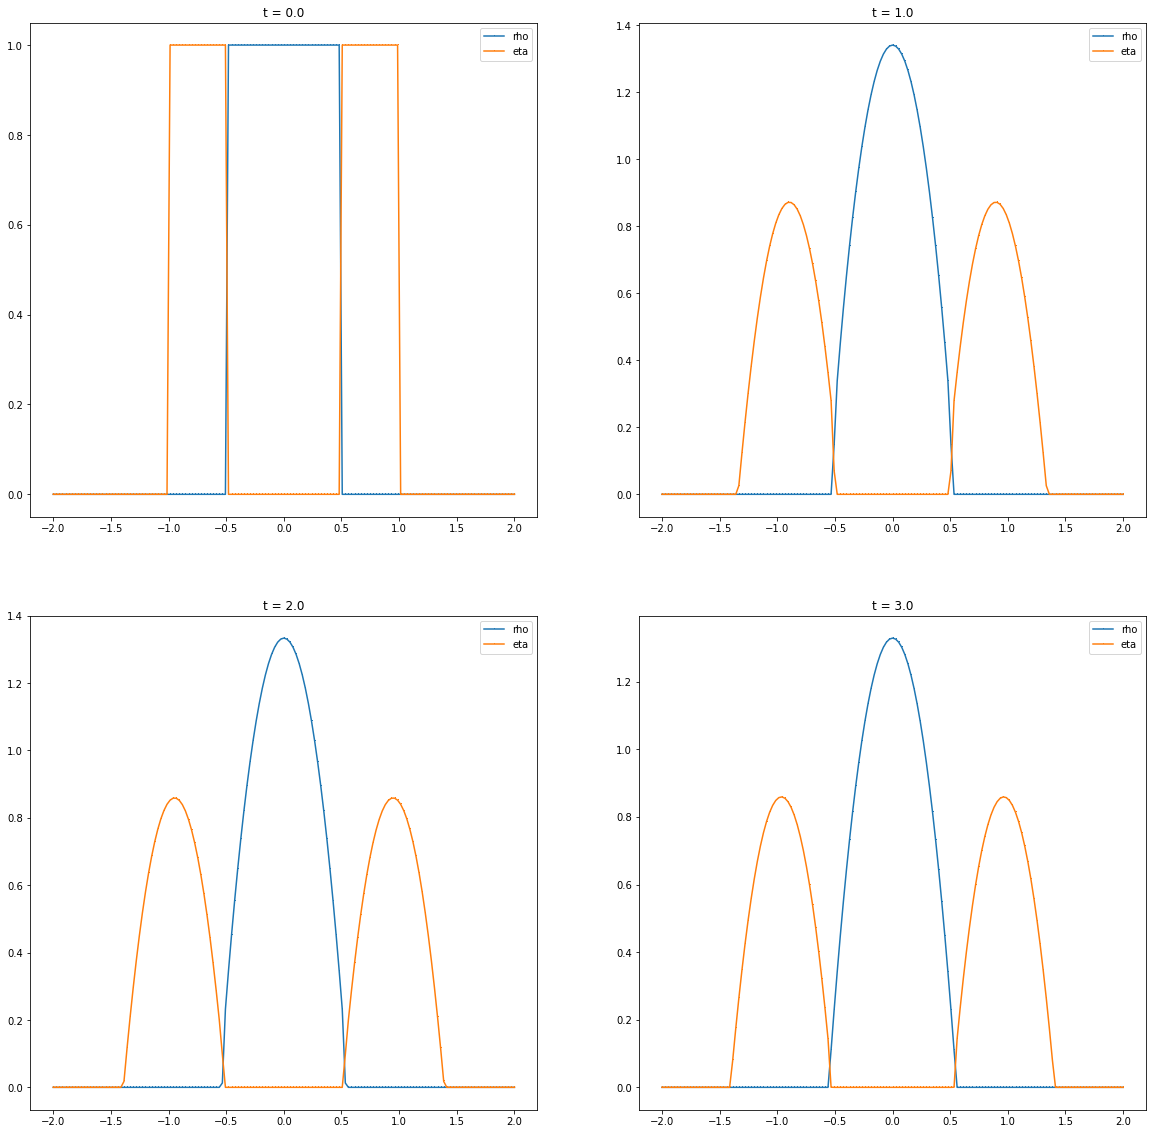

In [18]:
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(20,20))
length = rho.shape[0]
for i in range(2):
    for j in range(2):
        ax[j, i].plot(X, rho[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'rho')
        ax[j, i].plot(X, eta[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'eta')
        ax[j, i].set_title(f't = {(int((2*j + i)/3*(length-1)))*dt}')
        ax[j, i].legend()

## $\epsilon = \frac{1}{2}$

In [19]:
L = 2
eps = 0.5
m1 = 1
m2 = 1
T = 3
N = 150
dt = 0.0005

def rho0(x):
    if abs(x) >= 0 and abs(x) <= 0.5:
        return m1
    else:
        return 0
def eta0(x):
    if abs(x)>= 0.5 and abs(x) <= 1:
        return m2
    else:
        return 0
X = np.linspace(-L, L, N+1)
init_rho = np.array([rho0(x) for x in X])
init_eta = np.array([eta0(x) for x in X])

solver = aggregation_diffusion_2species(L, T, N, dt, eps, init_rho, init_eta)


rho, eta = solver.solve()

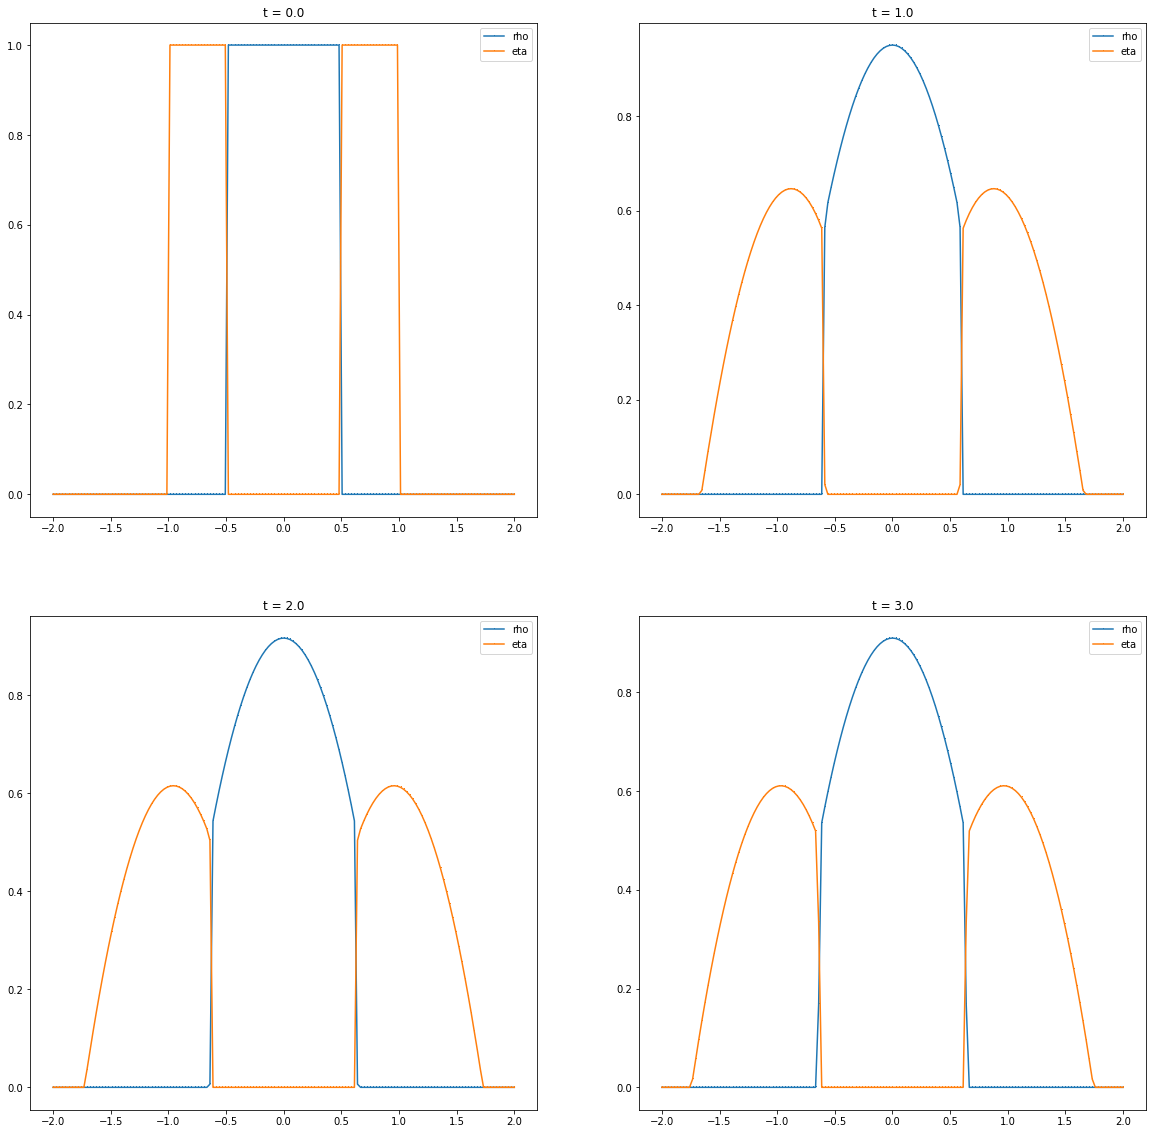

In [20]:
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(20,20))
length = rho.shape[0]
for i in range(2):
    for j in range(2):
        ax[j, i].plot(X, rho[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'rho')
        ax[j, i].plot(X, eta[int((2*j + i)/3*(length-1)), :], marker = ',', label = 'eta')
        ax[j, i].set_title(f't = {(int((2*j + i)/3*(length-1)))*dt}')
        ax[j, i].legend()